# proposal
gather data from film databasees to demonstrate which genre/writters/directors/actors in films are most profiatble at the box office, over a relatively short period of time

In [1]:
#pandas for reading data and converting them to DataFrameds for using Dataframe methods. 
#numpy for calculating said data
import pandas as pd
import numpy as np
#create graphs of the data that has been analyzed
import matplotlib.pyplot as plt
#make said graphs "prettier" and more enjoyable to read
import seaborn as sns
#view matplots in this notebook
%matplotlib inline

i need to gather films that were highest grossing at the box office. and if available, the names of directors, writters and actors in said films. 
Just to make sure my biases arent effecting the data too much, the rating for each film. 

after doing the below steps, i will go back to the origional data to see if there are other correlations

1) read all available databases and see what data is inside
2) covert to pandas Dataframes and remove columns that are not part of my hypothesis. 
3) join dataframes based on film title and get average rating
4) make four dataframes, one joined based on genre, one on writters, one on directors, one on actors, and make graphs
    for each based on pearson correlation, and see which has the highest correlation
    
the tables available *Box Office Mojo* database with gross revenue
*IMDB* databases with movie title, actors, directors, writters seperate tables

i will need to join those tables and order them by titles


after looking through all the databases and finding missing titles that were definitely profitable, i have decided to use
a joined dataframe with `The Numbers`, and `Watch Mojo` databases, and then join `IMDB` to it, to compare against.

### Import data, and put each table into a dataframe

In [2]:
imdb_film_title = pd.read_csv("unzipped-data/imdb.title.basics.csv")
imdb_film_title.head(2)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [3]:
box_mojo_gross = pd.read_csv("unzipped-data/bom.movie_gross.csv")
box_mojo_gross.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [4]:
people_involved_profession_relatedTitles = pd.read_csv("unzipped-data/imdb.name.basics.csv")
people_involved_profession_relatedTitles.head(2)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"


In [5]:
film_title_crew_reference_index = pd.read_csv("unzipped-data/imdb.title.crew.csv")
film_title_crew_reference_index.head(2)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"


In [6]:
job_title_category_index = pd.read_csv("unzipped-data/imdb.title.principals.csv")
job_title_category_index.head(2)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN


In [7]:
imdb_ratings_index = pd.read_csv("unzipped-data/imdb.title.ratings.csv")
imdb_ratings_index.head(2)

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [8]:
the_numbers_gross = pd.read_csv("unzipped-data/tn.movie_budgets.csv")
the_numbers_gross.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [9]:
the_numbers_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


# Data Cleaning

### `domestic_gross` data from The Numbers is in string format, we need it as Integers

In [10]:
the_numbers_gross['production_budget'] = the_numbers_gross['production_budget'].replace(to_replace=r'\D', value='', regex=True).astype(int)

In [11]:
the_numbers_gross['domestic_gross'] = the_numbers_gross['domestic_gross'].replace(to_replace=r'\D', value='', regex=True).astype(int)

In [12]:
the_numbers_gross['worldwide_gross'] = the_numbers_gross['worldwide_gross'].replace(to_replace=r'\D', value='', regex=True).astype(float)

In [13]:
the_numbers_gross['worldwide_gross'] = the_numbers_gross['worldwide_gross'].astype(int)

#### to join BoxMojo and TheNumbers data, it's easier if the columns have the same name

In [14]:
box_mojo_gross = box_mojo_gross.rename(columns={'title': 'movie'})

In [15]:
box_mojo_gross['movie'] = box_mojo_gross['movie'].astype(str)

In [16]:
the_numbers_gross['movie'] = the_numbers_gross['movie'].astype(str)

## use `sqldf` to join dataframes
it seems to work better, and i'm practicing SQL

In [17]:
from pandasql import sqldf

In [18]:
pysqldf = lambda q: sqldf(q, globals())

#### Join Box Office Mojo and The Numbers databases to get year and studio from BOM
The BOM database has less titles in it, and is not really worth using beyond the year and studio columns

In [19]:
q = '''
SELECT movie, the_numbers_gross.release_date, the_numbers_gross.production_budget, 
    the_numbers_gross.domestic_gross, the_numbers_gross.worldwide_gross, 
    box_mojo_gross.year, box_mojo_gross.studio
FROM the_numbers_gross
LEFT JOIN box_mojo_gross
USING(movie)
ORDER BY the_numbers_gross.domestic_gross
DESC
'''

mojo_numbers = pysqldf(q)
mojo_numbers.head(10)

,movie,release_date,production_budget,domestic_gross,worldwide_gross,year,studio
0,Star Wars Ep. VII: The Force Awakens,"Dec 18, 2015",306000000,936662225,2053311220,NaN,None
1,Avatar,"Dec 18, 2009",425000000,760507625,-2147483648,NaN,None
2,Black Panther,"Feb 16, 2018",200000000,700059566,1348258224,2018.0,BV
3,Avengers: Infinity War,"Apr 27, 2018",300000000,678815482,2048134200,2018.0,BV
4,Titanic,"Dec 19, 1997",200000000,659363944,-2147483648,NaN,None
5,Jurassic World,"Jun 12, 2015",215000000,652270625,1648854864,2015.0,Uni.
6,The Avengers,"May 4, 2012",225000000,623279547,1517935897,NaN,None
7,Star Wars Ep. VIII: The Last Jedi,"Dec 15, 2017",317000000,620181382,1316721747,NaN,None
8,Incredibles 2,"Jun 15, 2018",200000000,608581744,1242520711,2018.0,BV
9,The Dark Knight,"Jul 18, 2008",185000000,533720947,1001996207,NaN,None


checking data to make sure a popular movie is actually still in there

In [20]:
mojo_numbers.loc[mojo_numbers['movie'] == 'Jurassic Park']

,movie,release_date,production_budget,domestic_gross,worldwide_gross,year,studio
33,Jurassic Park,"Jun 11, 1993",63000000,395708305,1038812584,NaN,None


see how many rows are null, to see how much more cleaning is neccessary

In [21]:
mojo_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              5782 non-null   object 
 1   release_date       5782 non-null   object 
 2   production_budget  5782 non-null   int64  
 3   domestic_gross     5782 non-null   int64  
 4   worldwide_gross    5782 non-null   int64  
 5   year               1247 non-null   float64
 6   studio             1246 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 316.3+ KB


*The Numbers* used `Ep.` as an ebbreviation for `Episode` while *IMDB* doesn't

i would need to do a lot of string manipulation to get full data referenced

In [22]:
mojo_numbers['movie'] = mojo_numbers['movie'].replace(to_replace=r'Ep.', value=r'Episode', regex=True)

both `mojo_numbers` and IMDB have colons and dashes in them. i need to remove them to make the strings uniform

In [23]:
mojo_numbers['movie'] = mojo_numbers['movie'].replace(to_replace=r':|-.', value=r'', regex=True)

In [24]:
imdb_film_title['primary_title'] = imdb_film_title['primary_title'].replace(to_replace=r':|-.', value=r' ', regex=True)

remove white spaces

In [25]:
mojo_numbers['movie'] = mojo_numbers['movie'].replace('\s+', ' ', regex=True)

In [26]:
imdb_film_title['primary_title'] = imdb_film_title['primary_title'].replace('\s+', ' ', regex=True)

## get *average* domestic gross for use later

In [27]:
dom_gross_med = round(mojo_numbers['domestic_gross'].median())
dom_gross_med

17225945

the most importatnt columns for this Dataframe are `domestic_gross` and `worldwide_gross` which have no null values, so cleaning this Dataframe is done

### Merge `mojo_numbers` with IMDB dataframe to get movie ratings, and IMDB's `tconst` values
the `tconst` strings are references to columns on other IMDB dataframes

In [28]:
q = """
SELECT *
FROM mojo_numbers
LEFT JOIN imdb_film_title
ON mojo_numbers.movie = imdb_film_title.primary_title

"""

imdb_mojo_numbers = pysqldf(q)
imdb_mojo_numbers.head()

,movie,release_date,production_budget,domestic_gross,worldwide_gross,year,studio,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,Star Wars Episode VII The Force Awakens,"Dec 18, 2015",306000000,936662225,2053311220,NaN,None,tt2488496,Star Wars Episode VII The Force Awakens,Star Wars: Episode VII - The Force Awakens,2015.0,136.0,"Action,Adventure,Fantasy"
1,Avatar,"Dec 18, 2009",425000000,760507625,-2147483648,NaN,None,tt1775309,Avatar,Abatâ,2011.0,93.0,Horror
2,Black Panther,"Feb 16, 2018",200000000,700059566,1348258224,2018.0,BV,tt1825683,Black Panther,Black Panther,2018.0,134.0,"Action,Adventure,Sci-Fi"
3,Avengers Infinity War,"Apr 27, 2018",300000000,678815482,2048134200,2018.0,BV,tt4154756,Avengers Infinity War,Avengers: Infinity War,2018.0,149.0,"Action,Adventure,Sci-Fi"
4,Titanic,"Dec 19, 1997",200000000,659363944,-2147483648,NaN,None,tt2495766,Titanic,Titanic,2012.0,NaN,Adventure


#### check how mamy rows were on both tables

In [29]:
imdb_mojo_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7221 entries, 0 to 7220
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              7221 non-null   object 
 1   release_date       7221 non-null   object 
 2   production_budget  7221 non-null   int64  
 3   domestic_gross     7221 non-null   int64  
 4   worldwide_gross    7221 non-null   int64  
 5   year               1682 non-null   float64
 6   studio             1681 non-null   object 
 7   tconst             3798 non-null   object 
 8   primary_title      3798 non-null   object 
 9   original_title     3797 non-null   object 
 10  start_year         3798 non-null   float64
 11  runtime_minutes    3310 non-null   float64
 12  genres             3726 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 733.5+ KB


##### i'm not using all of the data
i've cut out several thousands of rows from the IMDB database, but retained all `domestic_gross` numbers from *The Numbers* database, because it's the only one available with data on actual sales

but where are the ~3200 films that were on *The Numbers* but not in IMDB ?

In [30]:
imdb_mojo_numbers.loc[imdb_mojo_numbers['tconst'].isna()]

,movie,release_date,production_budget,domestic_gross,worldwide_gross,year,studio,tconst,primary_title,original_title,start_year,runtime_minutes,genres
8,Star Wars Episode VIII The Last Jedi,"Dec 15, 2017",317000000,620181382,1316721747,NaN,None,None,None,None,NaN,NaN,None
10,The Dark Knight,"Jul 18, 2008",185000000,533720947,1001996207,NaN,None,None,None,None,NaN,NaN,None
16,Star Wars Episode I The Phantom Menace,"May 19, 1999",115000000,474544677,1027044677,NaN,None,None,None,None,NaN,NaN,None
17,Star Wars Episode IV A New Hope,"May 25, 1977",11000000,460998007,786598007,NaN,None,None,None,None,NaN,NaN,None
20,Shrek 2,"May 19, 2004",70000000,441226247,937008132,NaN,None,None,None,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7205,Manito,"Jun 13, 2003",25000,0,0,NaN,None,None,None,None,NaN,NaN,None
7211,Flywheel,"Dec 31, 2003",20000,0,0,NaN,None,None,None,None,NaN,NaN,None
7214,Steel Spirit,"Dec 1, 2003",20000,0,0,NaN,None,None,None,None,NaN,NaN,None
7217,Tin Can Man,"Dec 31, 2007",12000,0,0,NaN,None,None,None,None,NaN,NaN,None


do the `NaN` rows even exist in *IMDB* ?

In [31]:
imdb_film_title.loc[imdb_film_title['primary_title'] == 'Star Wars Episode VIII The Last Jedi']

,tconst,primary_title,original_title,start_year,runtime_minutes,genres


### thats WAY too many popular films without IMDB ratings!!!

are they at all found in IMDB?


In [32]:
imdb_film_title.loc[imdb_film_title['primary_title'].str.contains('Shreck')]

,tconst,primary_title,original_title,start_year,runtime_minutes,genres


we'll have to use what we've got

In [33]:
q = """
SELECT *
FROM imdb_mojo_numbers
LEFT JOIN imdb_ratings_index
USING(tconst)
ORDER BY domestic_gross

"""
# tconst, primary_title, start_year, genres, release_date,
#         production_budget, domestic_gross, worldwide_gross, year,
#         domestic_profit, intnl_profit

imdb_rat_mojo_num = pysqldf(q)

In [34]:
imdb_rat_mojo_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7221 entries, 0 to 7220
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              7221 non-null   object 
 1   release_date       7221 non-null   object 
 2   production_budget  7221 non-null   int64  
 3   domestic_gross     7221 non-null   int64  
 4   worldwide_gross    7221 non-null   int64  
 5   year               1682 non-null   float64
 6   studio             1681 non-null   object 
 7   tconst             3798 non-null   object 
 8   primary_title      3798 non-null   object 
 9   original_title     3797 non-null   object 
 10  start_year         3798 non-null   float64
 11  runtime_minutes    3310 non-null   float64
 12  genres             3726 non-null   object 
 13  averagerating      2857 non-null   float64
 14  numvotes           2857 non-null   float64
dtypes: float64(5), int64(3), object(7)
memory usage: 846.3+ KB


### add columns with profit

Add columns with `domestic_profit` and `international_profit` per film


profit defined as gross sales - budget

In [35]:
imdb_rat_mojo_num['domestic_profit'] = imdb_rat_mojo_num['domestic_gross'] - imdb_rat_mojo_num['production_budget']
imdb_rat_mojo_num['intnl_profit'] = imdb_rat_mojo_num['worldwide_gross'] - imdb_rat_mojo_num['production_budget']

## sort dataframe by domestic profit

In [36]:
top_gross = imdb_rat_mojo_num.sort_values('domestic_profit', ascending=False)
top_gross.head()

,movie,release_date,production_budget,domestic_gross,worldwide_gross,year,studio,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,domestic_profit,intnl_profit
7220,Star Wars Episode VII The Force Awakens,"Dec 18, 2015",306000000,936662225,2053311220,NaN,None,tt2488496,Star Wars Episode VII The Force Awakens,Star Wars: Episode VII - The Force Awakens,2015.0,136.0,"Action,Adventure,Fantasy",8.0,784780.0,630662225,1747311220
7218,Black Panther,"Feb 16, 2018",200000000,700059566,1348258224,2018.0,BV,tt1825683,Black Panther,Black Panther,2018.0,134.0,"Action,Adventure,Sci-Fi",7.3,516148.0,500059566,1148258224
7216,Titanic,"Dec 19, 1997",200000000,659363944,-2147483648,NaN,None,tt8852130,Titanic,Titanic,2018.0,115.0,Family,NaN,NaN,459363944,-2347483648
7215,Titanic,"Dec 19, 1997",200000000,659363944,-2147483648,NaN,None,tt2495766,Titanic,Titanic,2012.0,NaN,Adventure,6.2,20.0,459363944,-2347483648
7203,Star Wars Episode IV A New Hope,"May 25, 1977",11000000,460998007,786598007,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,449998007,775598007


# Make graph comparing production budget VS profit
to see if there is a concentration of a certain "price range" for a film
that would possibly hint to a limit of financial investment

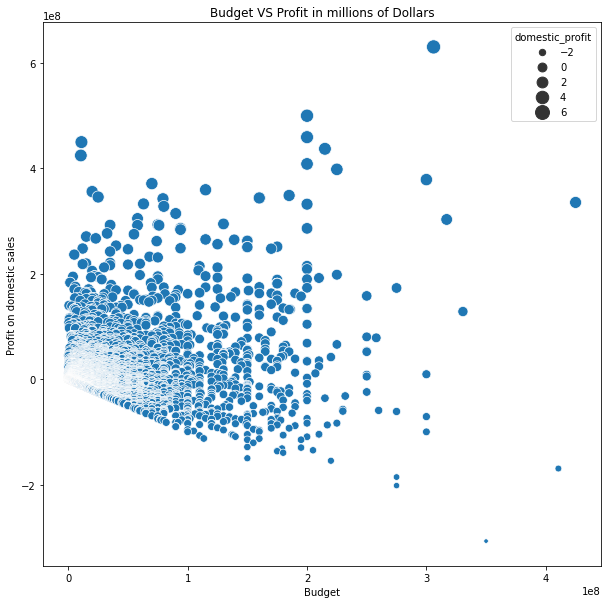

In [37]:
plt.figure(figsize=[10, 10])
sns.scatterplot(data=top_gross, 
                x='production_budget', 
                y='domestic_profit',
                size='domestic_profit',
                sizes=(20, 200))
plt.title("Budget VS Profit in millions of Dollars")
plt.xlabel("Budget")
plt.ylabel("Profit on domestic sales");

## same as above but for international sales

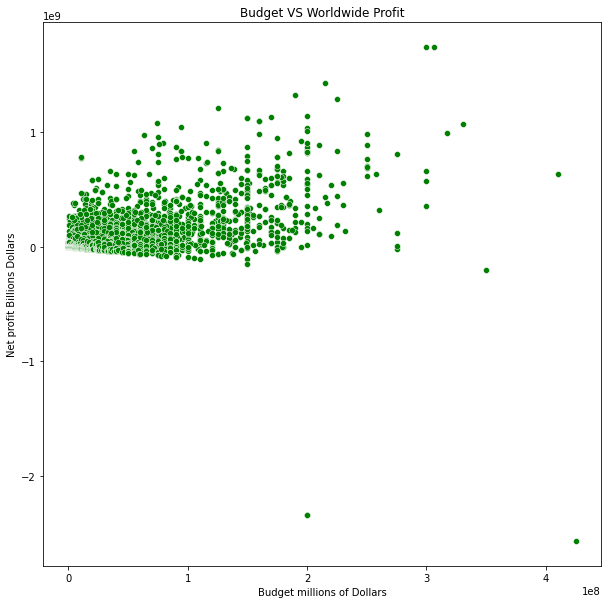

In [38]:
plt.figure(figsize=[10, 10])
sns.scatterplot(data=top_gross, 
                x='production_budget', 
                y='intnl_profit', color='green')
            
plt.title("Budget VS Worldwide Profit")
plt.xlabel("Budget millions of Dollars")
plt.ylabel("Net profit Billions Dollars");

### calculate standard deviation

In [39]:
standev_dom = round(top_gross['domestic_profit'].std(), 0)
standev_dom

48915659.0

In [40]:
better_than_avg_dom = top_gross.loc[top_gross['domestic_profit'] > standev_dom]
better_than_avg_dom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 7220 to 5834
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              767 non-null    object 
 1   release_date       767 non-null    object 
 2   production_budget  767 non-null    int64  
 3   domestic_gross     767 non-null    int64  
 4   worldwide_gross    767 non-null    int64  
 5   year               247 non-null    float64
 6   studio             247 non-null    object 
 7   tconst             379 non-null    object 
 8   primary_title      379 non-null    object 
 9   original_title     379 non-null    object 
 10  start_year         379 non-null    float64
 11  runtime_minutes    334 non-null    float64
 12  genres             371 non-null    object 
 13  averagerating      303 non-null    float64
 14  numvotes           303 non-null    float64
 15  domestic_profit    767 non-null    int64  
 16  intnl_profit       767

## same graph as above, but with films that made more than standard deviation

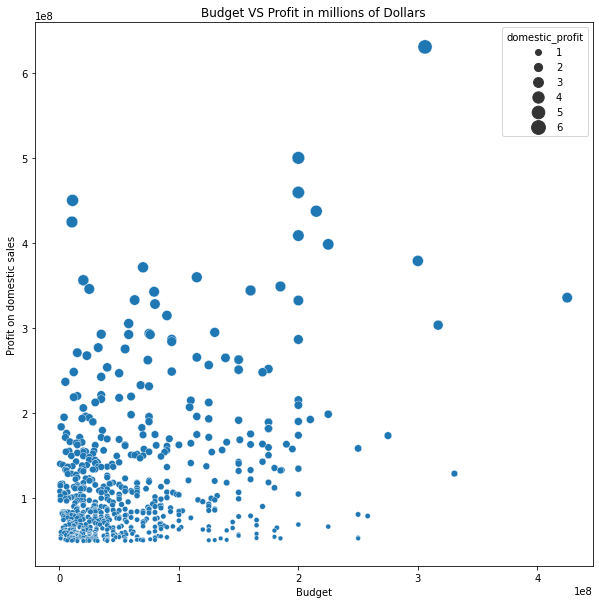

In [41]:
plt.figure(figsize=[10, 10])
sns.scatterplot(data=better_than_avg_dom, 
                x='production_budget', 
                y='domestic_profit', 
                size='domestic_profit',
                sizes=(20, 200))
plt.title("Budget VS Profit in millions of Dollars")
plt.xlabel("Budget")
plt.ylabel("Profit on domestic sales");

### join list of people to movies with ratings (not with profit)
the profit datafframe had significantly less rows, and i felt this would not give as accurate a portrayal.
instead opting to create adataframe with both sets and fill in null values with the average domestic profit

In [42]:
q = '''
SELECT top_gross.tconst, movie, primary_title, nconst, category, production_budget, genres,
        domestic_gross, worldwide_gross, averagerating, numvotes,
        domestic_profit, intnl_profit, AVG(domestic_gross) avg_sale_per_person
FROM job_title_category_index
JOIN top_gross
ON job_title_category_index.tconst = top_gross.tconst
GROUP BY nconst
'''

jobs_rating = pysqldf(q)
jobs_rating.head()

,tconst,movie,primary_title,nconst,category,production_budget,genres,domestic_gross,worldwide_gross,averagerating,numvotes,domestic_profit,intnl_profit,avg_sale_per_person
0,tt1566501,For Greater Glory The True Story of Cristiada,For Greater Glory The True Story of Cristiada,nm0000035,composer,12000000,"Drama,History,War",5669081,10026255,6.6,4202.0,-6330919,-1973745,5.669081e+06
1,tt2404435,The Magnificent Seven,The Magnificent Seven,nm0000041,writer,90000000,"Action,Adventure,Western",93432655,162525156,6.9,168514.0,3432655,72525156,9.343266e+07
2,tt1667150,What Women Want,What Women Want,nm0000084,actress,65000000,"Comedy,Romance,Sci-Fi",182805123,374105123,5.6,1152.0,117805123,309105123,8.403120e+07
3,tt1449283,Winnie the Pooh,Winnie the Pooh,nm0000092,actor,30000000,"Adventure,Animation,Comedy",26692846,50145607,7.2,19605.0,-3307154,20145607,7.368847e+07
4,tt1001526,Megamind,Megamind,nm0000093,actor,130000000,"Action,Animation,Comedy",148415853,321887208,7.3,207488.0,18415853,191887208,6.298790e+07


In [43]:
jobs_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22493 entries, 0 to 22492
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tconst               22493 non-null  object 
 1   movie                22493 non-null  object 
 2   primary_title        22493 non-null  object 
 3   nconst               22493 non-null  object 
 4   category             22493 non-null  object 
 5   production_budget    22493 non-null  int64  
 6   genres               22264 non-null  object 
 7   domestic_gross       22493 non-null  int64  
 8   worldwide_gross      22493 non-null  int64  
 9   averagerating        17948 non-null  float64
 10  numvotes             17948 non-null  float64
 11  domestic_profit      22493 non-null  int64  
 12  intnl_profit         22493 non-null  int64  
 13  avg_sale_per_person  22493 non-null  float64
dtypes: float64(3), int64(5), object(6)
memory usage: 2.4+ MB


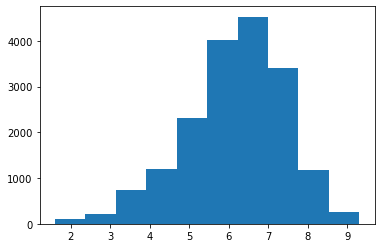

In [44]:
plt.hist(jobs_rating['averagerating']);

(array([232.,  76., 116.,  20.,   3.,   7.,  21.,   9.,   0.,   1.]),
 array([2.00050174e+08, 2.73711379e+08, 3.47372584e+08, 4.21033789e+08,
        4.94694994e+08, 5.68356199e+08, 6.42017405e+08, 7.15678610e+08,
        7.89339815e+08, 8.63001020e+08, 9.36662225e+08]),
 <BarContainer object of 10 artists>)

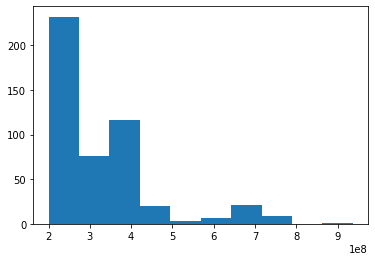

In [45]:
higher_sales = jobs_rating.loc[jobs_rating['avg_sale_per_person'] > 200000000]

plt.hist(higher_sales['avg_sale_per_person'], bins=10)

join names to `jobs_rating` dataframe

In [46]:
crew_names = pd.merge(jobs_rating, people_involved_profession_relatedTitles[['nconst', 'primary_name']], on='nconst')
crew_names.head()

,tconst,movie,primary_title,nconst,category,production_budget,genres,domestic_gross,worldwide_gross,averagerating,numvotes,domestic_profit,intnl_profit,avg_sale_per_person,primary_name
0,tt1566501,For Greater Glory The True Story of Cristiada,For Greater Glory The True Story of Cristiada,nm0000035,composer,12000000,"Drama,History,War",5669081,10026255,6.6,4202.0,-6330919,-1973745,5.669081e+06,James Horner
1,tt2404435,The Magnificent Seven,The Magnificent Seven,nm0000041,writer,90000000,"Action,Adventure,Western",93432655,162525156,6.9,168514.0,3432655,72525156,9.343266e+07,Akira Kurosawa
2,tt1667150,What Women Want,What Women Want,nm0000084,actress,65000000,"Comedy,Romance,Sci-Fi",182805123,374105123,5.6,1152.0,117805123,309105123,8.403120e+07,Li Gong
3,tt1449283,Winnie the Pooh,Winnie the Pooh,nm0000092,actor,30000000,"Adventure,Animation,Comedy",26692846,50145607,7.2,19605.0,-3307154,20145607,7.368847e+07,John Cleese
4,tt1001526,Megamind,Megamind,nm0000093,actor,130000000,"Action,Animation,Comedy",148415853,321887208,7.3,207488.0,18415853,191887208,6.298790e+07,Brad Pitt


#### get list of actors in popular movies

In [54]:
actors = crew_names.loc[jobs_rating['category'].str.contains('act|self', regex=True)]
actors

,tconst,movie,primary_title,nconst,category,production_budget,genres,domestic_gross,worldwide_gross,averagerating,numvotes,domestic_profit,intnl_profit,avg_sale_per_person,primary_name
2,tt1667150,What Women Want,What Women Want,nm0000084,actress,65000000,"Comedy,Romance,Sci-Fi",182805123,374105123,5.6,1152.0,117805123,309105123,8.403120e+07,Li Gong
3,tt1449283,Winnie the Pooh,Winnie the Pooh,nm0000092,actor,30000000,"Adventure,Animation,Comedy",26692846,50145607,7.2,19605.0,-3307154,20145607,7.368847e+07,John Cleese
4,tt1001526,Megamind,Megamind,nm0000093,actor,130000000,"Action,Animation,Comedy",148415853,321887208,7.3,207488.0,18415853,191887208,6.298790e+07,Brad Pitt
6,tt1038919,The Bounty Hunter,The Bounty Hunter,nm0000098,actress,45000000,"Action,Comedy,Romance",67061228,135808837,5.6,112444.0,22061228,90808837,6.348487e+07,Jennifer Aniston
7,tt1065073,Boyhood,Boyhood,nm0000099,actress,4000000,Drama,25379975,57273049,7.9,315584.0,21379975,53273049,2.537998e+07,Patricia Arquette
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22481,tt8692378,After,After,nm9968169,actor,650000,Adventure,0,0,NaN,NaN,-650000,-650000,0.000000e+00,Kiko Medrano IV
22482,tt8692378,After,After,nm9968170,actor,650000,Adventure,0,0,NaN,NaN,-650000,-650000,0.000000e+00,Leila Finn
22483,tt8671762,Jackpot,Jackpot,nm9970369,cinematographer,400000,"Comedy,Romance",44452,44452,7.8,18.0,-355548,-355548,4.445200e+04,Rana Sherry
22484,tt8713112,The Hunted,The Hunted,nm9979534,actress,55000000,"Adventure,Comedy,Drama",34234008,47213095,NaN,NaN,-20765992,-7786905,3.423401e+07,Tricia Thornton


(array([  39.,  104.,  319.,  513.,  957., 1575., 1737., 1244.,  494.,
         138.]),
 array([1.6 , 2.37, 3.14, 3.91, 4.68, 5.45, 6.22, 6.99, 7.76, 8.53, 9.3 ]),
 <BarContainer object of 10 artists>)

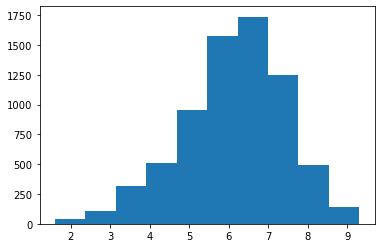

In [56]:
plt.hist(actors['averagerating'])

(array([8.658e+03, 4.880e+02, 1.110e+02, 5.400e+01, 2.900e+01, 4.000e+00,
        5.000e+00, 1.300e+01, 5.000e+00, 1.000e+00]),
 array([0.00000000e+00, 9.36662225e+07, 1.87332445e+08, 2.80998668e+08,
        3.74664890e+08, 4.68331112e+08, 5.61997335e+08, 6.55663558e+08,
        7.49329780e+08, 8.42996002e+08, 9.36662225e+08]),
 <BarContainer object of 10 artists>)

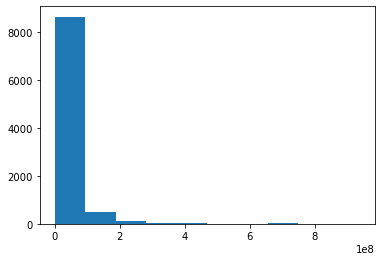

In [57]:
plt.hist(actors['domestic_gross'])

In [58]:
directors = crew_names.loc[jobs_rating['category'].str.contains('direc', regex=True)]
directors

,tconst,movie,primary_title,nconst,category,production_budget,genres,domestic_gross,worldwide_gross,averagerating,numvotes,domestic_profit,intnl_profit,avg_sale_per_person,primary_name
5,tt1605783,Midnight in Paris,Midnight in Paris,nm0000095,director,30000000,"Comedy,Fantasy,Romance",56816662,162502774,7.7,356500.0,26816662,132502774,2.753843e+07,Woody Allen
48,tt2119532,Hacksaw Ridge,Hacksaw Ridge,nm0000154,director,40000000,"Biography,Drama,History",67209615,168904682,8.1,366904.0,27209615,128904682,2.390050e+07,Mel Gibson
95,tt0970179,Hugo,Hugo,nm0000217,director,180000000,"Adventure,Drama,Family",73864507,180047784,7.5,284869.0,-106135493,47784,8.146958e+07,Martin Scorsese
108,tt1615065,Savages,Savages,nm0000231,director,45000000,"Crime,Drama,Thriller",47323100,82513490,6.5,115793.0,2323100,37513490,3.445531e+07,Oliver Stone
109,tt1853728,Django Unchained,Django Unchained,nm0000233,director,100000000,"Drama,Western",162805434,449948323,8.4,1211405.0,62805434,349948323,1.084614e+08,Quentin Tarantino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22433,tt8633834,The Bucket List,The Bucket List,nm9940260,actor,45000000,"Adventure,Comedy",93466502,174807445,NaN,NaN,48466502,129807445,9.346650e+07,Micah Jaeger
22452,tt8662424,Never Again,Never Again,nm9952477,composer,500000,Drama,307631,308793,5.7,67.0,-192369,-191207,3.076310e+05,Ben Gordelia
22466,tt8680408,The Circle,The Circle,nm9961942,director,18000000,Drama,20497844,40651864,NaN,NaN,2497844,22651864,2.049784e+07,Sarah R. Larson
22468,tt8680408,The Circle,The Circle,nm9961944,actress,18000000,Drama,20497844,40651864,NaN,NaN,2497844,22651864,2.049784e+07,Leah Drexler


In [60]:
writers = crew_names.loc[jobs_rating['category'].str.contains('writ', regex=True)]
writers

,tconst,movie,primary_title,nconst,category,production_budget,genres,domestic_gross,worldwide_gross,averagerating,numvotes,domestic_profit,intnl_profit,avg_sale_per_person,primary_name
1,tt2404435,The Magnificent Seven,The Magnificent Seven,nm0000041,writer,90000000,"Action,Adventure,Western",93432655,162525156,6.9,168514.0,3432655,72525156,9.343266e+07,Akira Kurosawa
14,tt1430612,Brick Mansions,Brick Mansions,nm0000108,writer,28000000,"Action,Crime",20396829,73421224,5.7,37528.0,-7603171,45421224,4.613584e+07,Luc Besson
20,tt0437086,Alita Battle Angel,Alita Battle Angel,nm0000116,writer,170000000,"Action,Adventure,Sci-Fi",85710210,402976036,7.5,88207.0,-84289790,232976036,8.773558e+07,James Cameron
22,tt1502407,Halloween,Halloween,nm0000118,writer,325000,"Horror,Thriller",47000000,70000000,6.6,88395.0,46675000,69675000,6.973451e+07,John Carpenter
27,tt1179056,A Nightmare on Elm Street,A Nightmare on Elm Street,nm0000127,writer,1800000,"Crime,Drama,Horror",25504513,25504513,5.2,85497.0,23704513,23704513,3.537622e+07,Wes Craven
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22424,tt10351040,Trash,Trash,nm9923965,actor,12000000,Thriller,17484,6553186,NaN,NaN,-11982516,-5446814,1.748400e+04,Ruric Douglas
22441,tt8648232,Aberdeen,Aberdeen,nm9946206,composer,6500000,Drama,64148,64148,NaN,NaN,-6435852,-6435852,6.414800e+04,Jamal Green
22442,tt8643442,Virus,Virus,nm9946464,actor,75000000,Action,14010690,30626690,NaN,NaN,-60989310,-44373310,1.401069e+07,Anupam Mishra
22471,tt8680408,The Circle,The Circle,nm9961951,actor,18000000,Drama,20497844,40651864,NaN,NaN,2497844,22651864,2.049784e+07,Josh Tysver


### making graphs of popular Writers, Directors and Actors

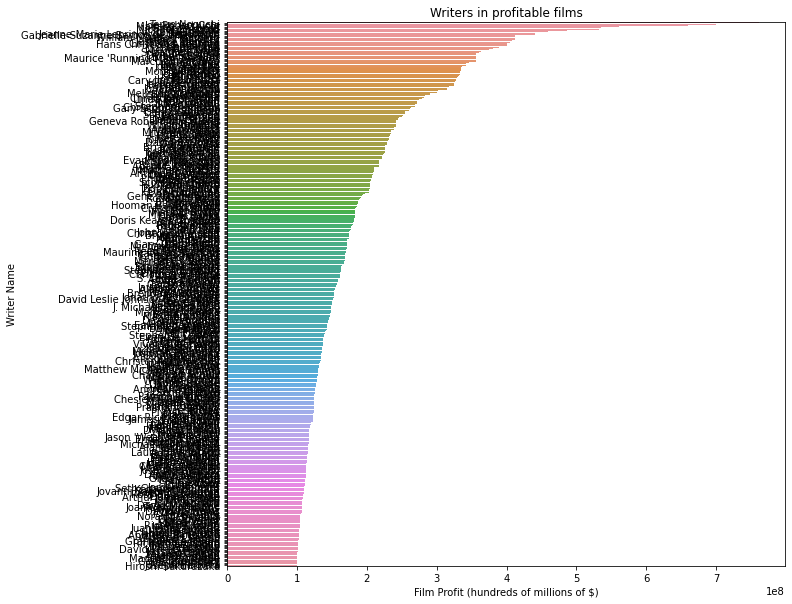

In [68]:
prof_writ = writers.loc[writers['avg_sale_per_person'] > 100000000]

writers_who_made_it = prof_writ.sort_values('avg_sale_per_person', ascending=False)

plt.figure(figsize=[10, 10])
sns.barplot(data=writers_who_made_it, x='avg_sale_per_person', y='primary_name')
plt.title("Writers in profitable films")
plt.xlabel('Film Profit (hundreds of millions of $)')
plt.ylabel('Writer Name');

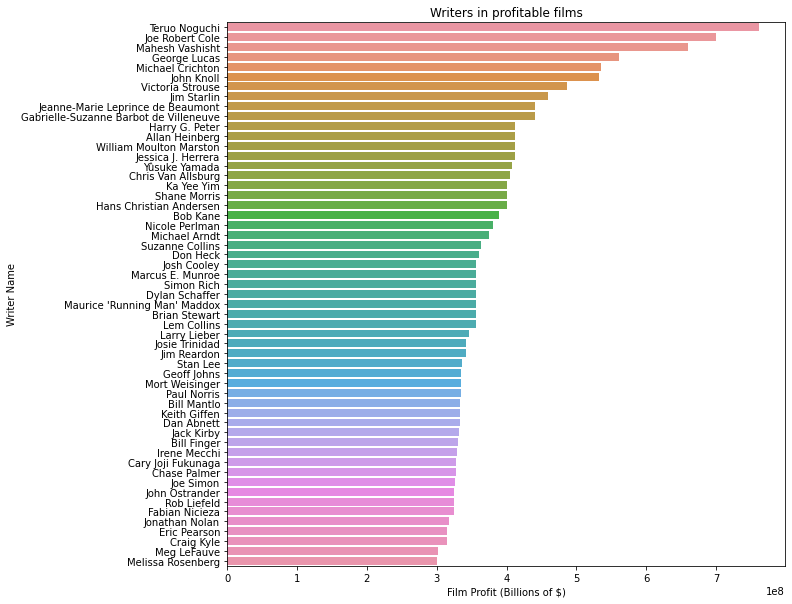

In [70]:
prof_writ = writers.loc[writers['avg_sale_per_person'] > 300000000]

writers_who_made_it = prof_writ.sort_values('avg_sale_per_person', ascending=False)

plt.figure(figsize=[10, 10])
sns.barplot(data=writers_who_made_it, x='avg_sale_per_person', y='primary_name')
plt.title("Writers in profitable films")
plt.xlabel('Film Profit (hundreds of millions of $)')
plt.ylabel('Writer Name');

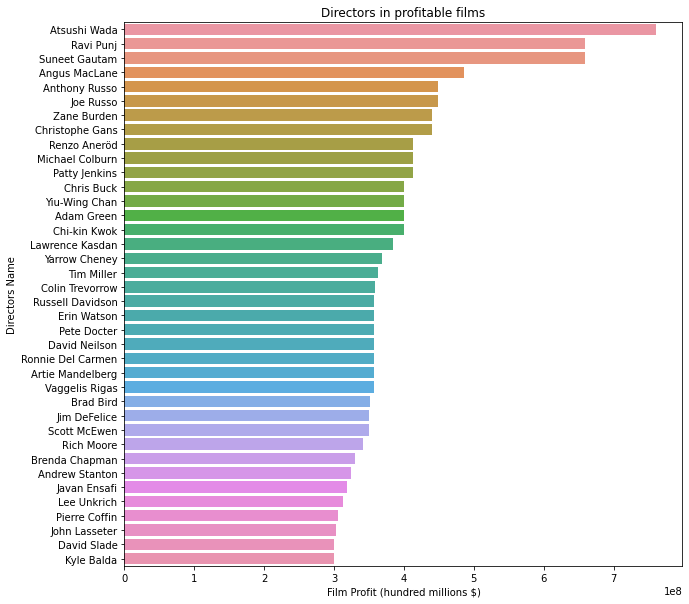

In [74]:
prof_direct = directors.loc[directors['avg_sale_per_person'] > 300000000]

dir_who_made_it = prof_direct.sort_values('avg_sale_per_person', ascending=False)

plt.figure(figsize=[10, 10])
sns.barplot(data=dir_who_made_it, x='avg_sale_per_person', y='primary_name')
plt.title("Directors in profitable films")
plt.xlabel('Film Profit (hundred millions $)')
plt.ylabel('Directors Name');

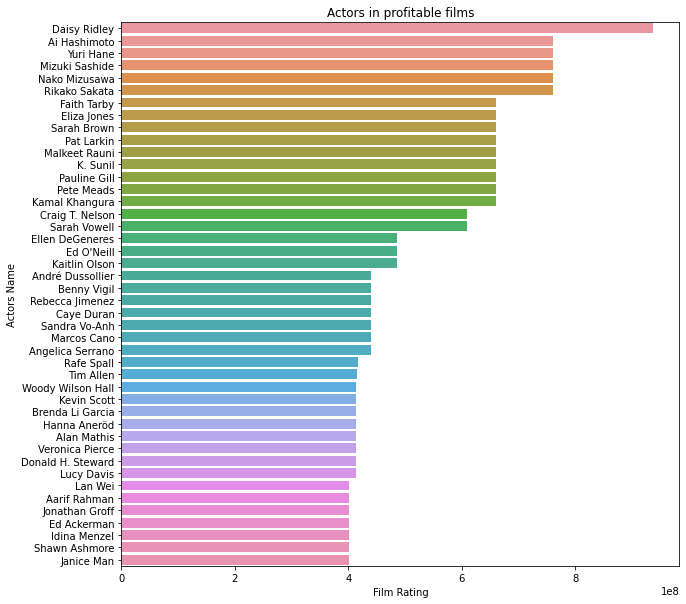

In [77]:
prof_act = actors.loc[actors['avg_sale_per_person'] > 400000000]

act_who_made_it = prof_act.sort_values('avg_sale_per_person', ascending=False)

plt.figure(figsize=[10, 10])
sns.barplot(data=act_who_made_it, x='avg_sale_per_person', y='primary_name')
plt.title("Actors in profitable films")
plt.xlabel('Film Rating')
plt.ylabel('Actors Name');

#### actors appear to have made a LOT more money on average
but the reality is, the data set just includes more actors than directors and writers

## Group data by Genre, and see which Genre is best performing

In [79]:
q = '''
SELECT top_gross.tconst, movie, primary_title, nconst, category, production_budget, genres,
        domestic_gross, worldwide_gross, averagerating, numvotes,
        domestic_profit, intnl_profit, AVG(domestic_gross) avg_sale_per_genre
FROM job_title_category_index
JOIN top_gross
ON job_title_category_index.tconst = top_gross.tconst
GROUP BY genres
'''

genre_rating = pysqldf(q)
genre_rating.head()

,tconst,movie,primary_title,nconst,category,production_budget,genres,domestic_gross,worldwide_gross,averagerating,numvotes,domestic_profit,intnl_profit,avg_sale_per_genre
0,tt1472211,The Bounty Hunter,The Bounty Hunter,nm1159038,actress,45000000,None,67061228,135808837,6.3,29.0,22061228,90808837,3.954921e+07
1,tt1230120,Collide,Collide,nm2698026,actor,29200000,Action,2280004,5466698,5.5,12.0,-26919996,-23733302,2.495732e+07
2,tt1460743,Reign of Assassins,Reign of Assassins,nm0436348,composer,14000000,"Action,Adventure",0,11354230,6.9,6990.0,-14000000,-2645770,3.786088e+07
3,tt0983193,The Adventures of Tintin,The Adventures of Tintin,nm0001392,producer,130000000,"Action,Adventure,Animation",77591831,373993951,7.3,202430.0,-52408169,243993951,1.567252e+08
4,tt1390411,In the Heart of the Sea,In the Heart of the Sea,nm0004976,producer,100000000,"Action,Adventure,Biography",25020758,89693309,6.9,108628.0,-74979242,-10306691,5.671719e+07


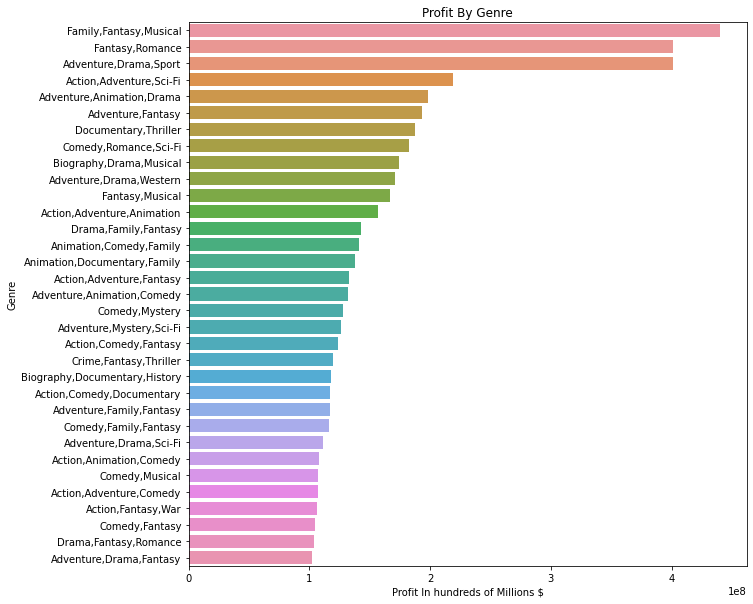

In [86]:
filtered_generes = genre_rating.loc[genre_rating['avg_sale_per_genre'] > 100000000]
top_genres = filtered_generes.sort_values('avg_sale_per_genre', ascending=False)

plt.figure(figsize=[10, 10])
sns.barplot(data=top_genres, x='avg_sale_per_genre', y='genres')
plt.title("Profit By Genre")
plt.xlabel('Profit In hundreds of Millions $')
plt.ylabel('Genre');

where i messed up
1) should have made smaller data sets to THEN `join`
2) should have used somethingbesides bar charts from people
3) importing scipy was useless


if i had more time i would have scraped more data from the web, 
used The Numbers API to get more recent and complete data
and used IMDB's API to get more recent data about films